<a href="https://colab.research.google.com/github/440g/Machine5/blob/Open-Binary/Open-Binary/binary_open_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# 2. Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
mon_features = pd.read_csv('/content/drive/MyDrive/ML/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/ML/mon_labels.csv')

unmon_features = pd.read_csv('/content/drive/MyDrive/ML/unmon_features.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Combine datasets
features_modified = pd.concat([mon_features, unmon_features], ignore_index=True)

# Assign labels
mon_labels = np.ones(len(mon_features))
unmon_labels = -np.ones(len(unmon_features))
labels = np.concatenate([mon_labels, unmon_labels])

In [4]:
#check the shape of mon_features
print(mon_features.head())

#check the shape of unmon_features
print(unmon_features.head())

   total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0       1421        -603648   4.315749       1300   4.292023    5579.63   
1        518        -183296   4.611815        438   4.673242    2046.88   
2       1358        -574464   5.488969       1240   5.459452    6769.72   
3       1446        -615424   5.995512       1324   5.948693    7876.07   
4       1406        -602112   4.698869       1291   4.663873    6021.06   

   inpkt_num_frac_total  inpkt_avg_ordering  inpkt_std_ordering  \
0              0.914849          704.106154          398.486335   
1              0.845560          264.406393          150.591146   
2              0.913108          668.259677          381.878642   
3              0.915629          713.503021          406.205288   
4              0.918208          694.740511          395.028889   

   inpkt_num_frac_outpkt  inpkt_sum_firstn  outpkt_num  outpkt_avg  \
0              10.743802             16.10         121    4.570661   
1     

# 3. Preprocess Data

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_modified, labels, test_size=0.2, random_state=1
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Build and Train the RandomForest Model

In [6]:
# Train Random Forest model
rf_binary = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_binary.fit(X_train_scaled, y_train)

# Evaluate model on test data
y_pred = rf_binary.predict(X_test_scaled)

# Calculate basic evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.8472
Precision: 0.8733
Recall: 0.9018
Confusion Matrix:
[[1426  506]
 [ 380 3488]]


# 5. Hyperparameter Tuning

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [10, 20, 30, 40, 50],
    'max_leaf_nodes': [100, 200, 300],
    'class_weight': ['balanced']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_binary, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Retrieve best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)

# 6. Evaluate the Tuned Model

In [8]:
# Predict using the tuned model
y_pred_best = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=1)
recall_best = recall_score(y_test, y_pred_best, pos_label=1)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_best, pos_label=1)
roc_auc_best = auc(fpr_best, tpr_best)

precision_values_best, recall_values_best, _ = precision_recall_curve(y_test, y_pred_best, pos_label=1)
pr_auc_best = auc(recall_values_best, precision_values_best)

# Display results
print(f"Tuned Model Accuracy: {accuracy_best:.4f}")
print(f"Tuned Model Precision: {precision_best:.4f}")
print(f"Tuned Model Recall: {recall_best:.4f}")
print(f"Tuned Model ROC AUC: {roc_auc_best:.4f}")
print(f"Tuned Model PR AUC: {pr_auc_best:.4f}")
print(f"Tuned Model Confusion Matrix:\n{conf_matrix_best}")

Tuned Model Accuracy: 0.8212
Tuned Model Precision: 0.8953
Tuned Model Recall: 0.8289
Tuned Model ROC AUC: 0.8174
Tuned Model PR AUC: 0.9191
Tuned Model Confusion Matrix:
[[1557  375]
 [ 662 3206]]


# Visualize Results

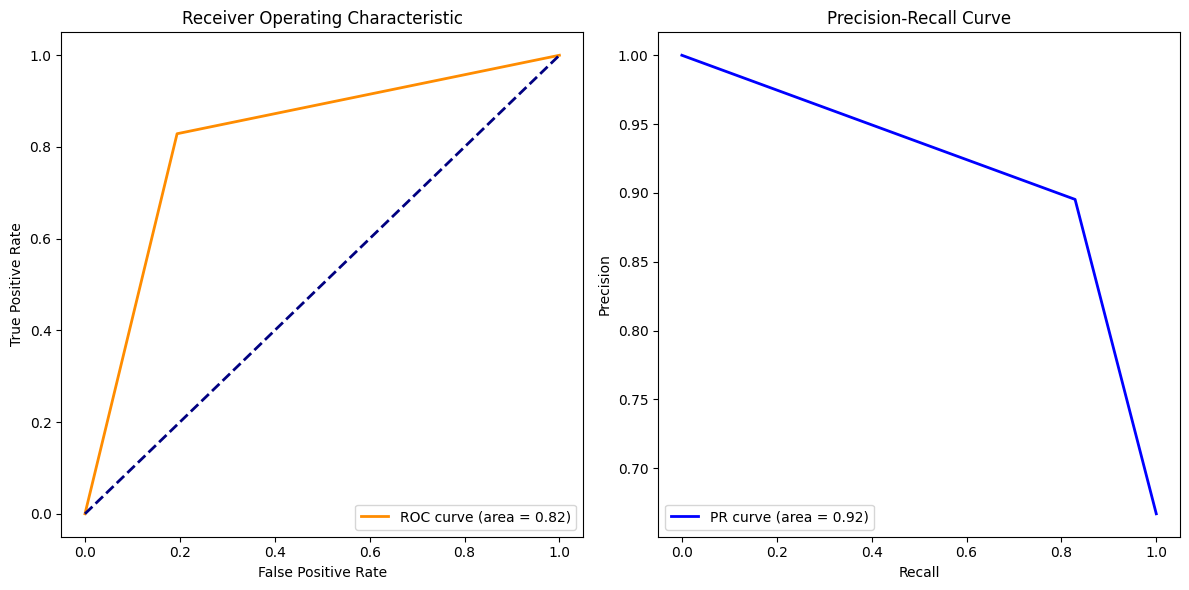

In [9]:
# ROC Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values_best, precision_values_best, color='blue', lw=2, label=f'PR curve (area = {pr_auc_best:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()